## 식료품예측 데이터

데이터 경로  
https://www.kaggle.com/c/instacart-market-basket-analysis/overview/evaluation

데이터 상세 설명  
https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2
<!-- For each orderid in the test set, you should predict a space-delimited list of productids for that order. If you wish to predict an empty order, you should submit an explicit 'None' value. You may combine 'None' with product_ids. The spelling of 'None' is case sensitive in the scoring metric. The file should have a header and look like the following:

해당 competition은 test 셋의 orderid에 대해 products가 공백으로 되어있는 부분을 예측해야한다. 빈 주문이라고(주문X) 예측하고 싶으면 'None'으로 제출하면됨. -->

해당 competition의 목적은 사용자별로 지금까지 구매한 상품들 중 이후에도 재구매(reorder)할 상품에 대해 예측하는 것

In [1]:
import pandas as pd
import numpy as np
import torch
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '/home/jovyan/work/old_nas/workspace/2_shared/TDI_BASD/02_Data/Instacart/01_og_data/'

## 데이터 목록
file_list = os.listdir(path)

for file in file_list : 
    s = os.path.getsize(path + file)
    print(file, " :\t %.2f MB" % (s / (1024.0 * 1024.0)))  # 메가바이트 단위로

products.csv  :	 2.07 MB
departments.csv  :	 0.00 MB
orders.csv  :	 103.92 MB
sample_submission.csv  :	 1.41 MB
order_products__prior.csv  :	 550.80 MB
.ipynb_checkpoints  :	 0.00 MB
aisles.csv  :	 0.00 MB
order_products__train.csv  :	 23.54 MB


 aisles.csv                :  상품 중분류에 대한 정보  
 products.csv              :  상품 id에 대한 정보  
 order_products__prior.csv :  상품 구매이력(사용자별로 여러개의 구매이력이 있음)  
 order_products__train.csv :  상품 구매이력(사용자별 가장 최근에 구매한 이력만 저장)  
 sample_submission.csv     :  test set 제출 형식(test set의 key columns)  
 orders.csv                :  마켓 방문 이력(방문요일, 시간 등.. test set도 여기 포함됨)  
 departments.csv           :  상품 대분류에 대한 정보  

## order products
- order_id(영수증번호) 별로 구매한 상품과 그 순서, 재구매 여부가 있는 데이터
- prior(이전에 구매한 기록), train(실제 학습할 데이터, 사용자 별로 가장 최근 방문 이력만 있음) 으로 나뉜다. 
    - order_id : 영수증 번호
    - product_id : 상품 고유번호
    - add_to_cart_order : 영수증 번호 별 상품을 장바구니에 담은 순서
    - reordered : 해당 상품을 사용자가 이전에 산 적이 있는지에 대한 여부
    
<br>

- reordered가 우리의 target은 아님, 추후 따로 target을 지정함

In [3]:
order_prior = pd.read_csv(path + 'order_products__prior.csv')

order_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [4]:
order_prior.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


- order_id : 주문번호(영수증번호 같은 것)
    - 총 **3,421,083건의** 주문이 있었음
- product_id : 상품ID
    - 49688개의 상품으로 추정
- add_to_cart_order : 상품을 주문한 순서 (order id 딩)
    - 최소 1개만, 최대 145개까지 장바구니에 담음. 
    - 보통은 10개 내외로 구매하는 것으로 보임
- reordered : 이전에 주문한 이력이 있는지

## order products train

In [5]:
order_train = pd.read_csv(path + 'order_products__train.csv')

In [6]:
order_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


## order

- eval_set : 데이터 셋 구분
- order_number : 몇번째 구매인지(마트에서 구매한 횟수)
- order_dow : 요일 구분
- order_hour_of_day ; 구매 시간
- days_since_prior_order : 이전 주문까지 걸린 일자(?) -> 몇일만에 재방문한건지(첫번째 방문은 NA임)

In [7]:
order = pd.read_csv(path + 'orders.csv')
order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [8]:
order.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [9]:
order.user_id.nunique()

206209

## product

In [10]:
product = pd.read_csv(path + 'products.csv')
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [11]:
print("product_id : ",product.product_id.nunique())
print("aisle_id : ",product.aisle_id.nunique())
print("department_id : ",product.department_id.nunique())

product_id :  49688
aisle_id :  134
department_id :  21


총 약 5만개의 상품. 134개의 aisle(중분류) class, 21개의 department(대분류) class 가 있음

## department

In [12]:
department = pd.read_csv(path + 'departments.csv')
department

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


## aisles.csv

In [13]:
aisles = pd.read_csv(path + 'aisles.csv')
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


# EDA

In [14]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### train 주문 내역 보기

In [15]:
order_train_ = pd.merge(pd.merge(pd.merge(order_train, product,
                                          how = 'left', on = 'product_id'), aisles,
                                 how = 'left', on = 'aisle_id'), department,
                       how = 'left', on = 'department_id')

In [16]:
order_train_.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [17]:
## 한번의 구매정보
order_train_[order_train_.order_id == 1]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
5,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce
6,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce
7,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs


In [18]:
## order 별 구매한 상품 개수 통계
print(order_train_.groupby('order_id').product_id.count().describe())

count    131209.000000
mean         10.552759
std           7.932847
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max          80.000000
Name: product_id, dtype: float64


- 평균적으로 한번 구매할때 10개 내외의 상품을 구매함
- 최대로 80개까지 구매한 사용자도 있음

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='product_id', ylabel='Density'>

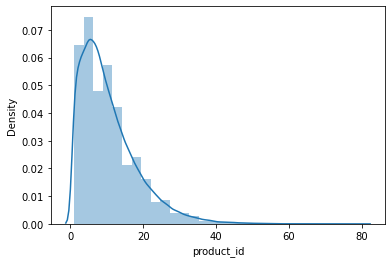

In [19]:
sns.distplot(order_train_.groupby('order_id').product_id.count(),
             hist = True, kde = True, bins = 30)

평균적으로 10개정도의 상품을 구매함.

count    131209.000000
mean          7.551075
std           4.999645
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          44.000000
Name: aisle_id, dtype: float64


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='aisle_id', ylabel='Density'>

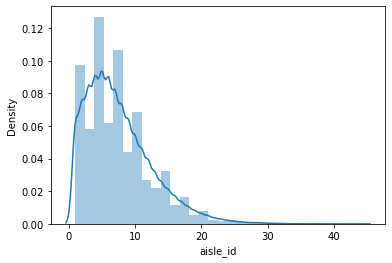

In [20]:
## order 별 aisle_id 종류 개수 통계
print(order_train_.groupby('order_id').aisle_id.nunique().describe())

sns.distplot(order_train_.groupby('order_id').aisle_id.nunique(),
             hist = True, kde = True, bins = 30)

- 장바구니 안에 aisle_id의 종류는 평균적으로 7개
    - 같은 aisle 1~2개의 상품들을 구매함

count    131209.000000
mean          4.880694
std           2.642694
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          16.000000
Name: department, dtype: float64


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='department'>

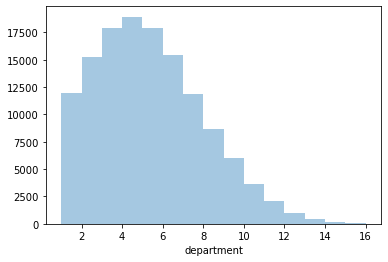

In [21]:
## order 별 department_id 종류 개수 통계
print(order_train_.groupby('order_id').department.nunique().describe())

sns.distplot(order_train_.groupby('order_id').department.nunique(),
             hist = True, kde = False, bins = 15)

한번 구매할 때 department가 평균적으로 5번 정도 있음

In [22]:
print(order[order.eval_set == 'train'].order_number.min())
print(order[order.eval_set == 'train'].order_number.max())

4
100


## order eda

In [23]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [24]:
order[order.eval_set == 'test']

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


count    131209.000000
mean         16.603937
std          16.661077
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_number'>

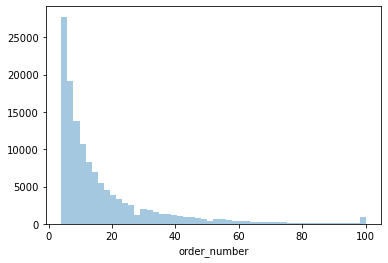

In [25]:
print(order[order.eval_set == 'train'].order_number.describe())

sns.distplot(order[order.eval_set == 'train'].order_number,
             hist = True, kde = False, bins = 50)

- 사용자별로 방문이력이 최근 4번부터 100번 사이에 있음
- 평균적으로 10번정도 방문이력이 있음

count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64


<AxesSubplot:xlabel='days_since_prior_order'>

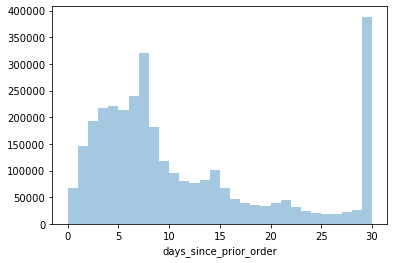

In [26]:
print(order[order['days_since_prior_order'].notnull()]['days_since_prior_order'].describe())

sns.distplot(order[order['days_since_prior_order'].notnull()]['days_since_prior_order'],
             hist = True, kde = False, bins = 30)

- 한달만에 구매하는 사람 수가 꽤 많음. 정말 한달만의 재방문인지 잘 모르겠음.
    - 아마도 30일 이후는 clipping하는 것 같음
- 30일을 제외하면 보통 일주일에 한번씩 방문함

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='order_dow'>

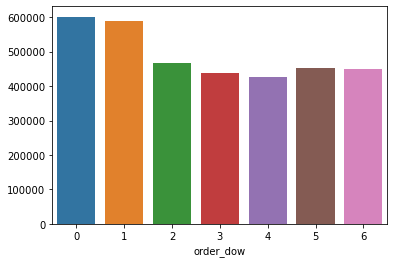

In [27]:
print(order['order_dow'].value_counts())

sns.barplot(order.groupby(['order_dow']).size().index, 
            order.groupby(['order_dow']).size())

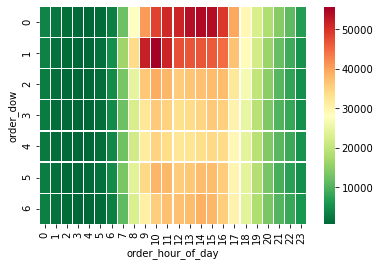

In [35]:
# 구매시간 X 
tmp = order.groupby(['order_dow', 'order_hour_of_day']).size().reset_index()
tmp = tmp.pivot("order_dow","order_hour_of_day", 0)

sns.heatmap(tmp, cmap='RdYlGn_r', linewidths = 0.1)
plt.show()

- 0이 언젠지 모르겠지만(일? 월?) 0, 1 이 제일 많이 구매
- 보통 8시 ~ 17시 사이에(한국에서 영업시간과 비슷) 보통 많이 구매
- 0, 1요일의 영업시간에 구매를 가장 많이 하는 듯 함

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='order_hour_of_day'>

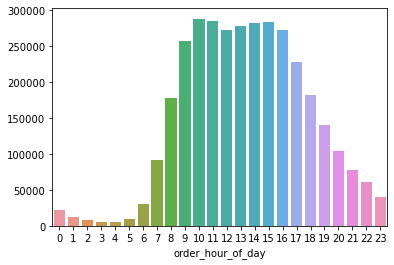

In [101]:
## 상품 구매 시간대
sns.barplot(order.groupby(['order_hour_of_day']).size().index, 
            order.groupby(['order_hour_of_day']).size())

- 구매시간대를 그룹핑할 필요성도 있다고 봄.
- 새벽구매자도 적지는 않은것 같다. 

In [ ]:
torch.save(order_train_, './tmp_data/order_train_join.p')

- user_id 관련해서는 user에 대한 정보가 없음
- 구매 이력만 있을 뿐이므로 행동패턴만 볼 수 있음

In [83]:
order_train_.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
